# Philadelphia Synthetic Trajectory Data - Analysis

This notebook analyzes synthetic data for 200 users in Philadelphia generated with the traj_gen.py module of the nomad library. For reference, we also examine the ground-truth travel diaries of individuals indicating the dwells and POIs of each segment of their trajectories. We also report on the completeness of the generated data, which varies due to induced sparsity and irregularity in the sampling of ping times.  

## Data Sources
- **Device-level trajectories**: Individual location pings (x, y coordinates)
- **Stop tables**: Ground truth stops derived from the trajectories
- **POI data**: OpenStreetMap points of interest used for simulation

In [ ]:
!pip install git+https://github.com/Watts-Lab/nomad.git

In [ ]:
!pip install contextily geopandas

In [2]:
import nomad.io.base as loader
import nomad.filters as filters
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import nomad.stop_detection.viz as viz

## 1. Data Loading

We use `nomad.io.base.from_file()` to load trajectory and stop data from S3. 
This function handles Parquet datasets and automatically sorts by user_id and timestamp.

In [3]:
DEVICE_LEVEL_PATH = "s3://catalog-csslab/phl_synthetic_200/device_level/"
STOP_TABLES_PATH = "s3://catalog-csslab/phl_synthetic_200/stop_tables/ground_truth/"
POI_DATA_PATH = "s3://catalog-csslab/phl_synthetic_200/poi_data/osm_sample_phl_200/poi_gdf_phl_200.parquet"

device_df = loader.from_file(DEVICE_LEVEL_PATH, format="parquet")
stop_df = loader.from_file(STOP_TABLES_PATH, format="parquet")
poi_gdf = gpd.read_parquet(POI_DATA_PATH)

print(f"Loaded {len(device_df):,} pings for {device_df['user_id'].nunique()} users")
print(f"Loaded {len(stop_df):,} stops")
print(f"Date range: {device_df['event_start_date'].min()} to {device_df['event_start_date'].max()}")

C:\Users\pacob\Desktop\Brain\Code Development\nomad\nomad\io\base.py:599: UserWarning: The 'datetime' column is timezone-naive. Consider localizing or using unix timestamps.
  warnings.warn(f"The '{col}' column is timezone-naive. Consider localizing or using unix timestamps.")
C:\Users\pacob\Desktop\Brain\Code Development\nomad\nomad\io\base.py:599: UserWarning: The 'datetime' column is timezone-naive. Consider localizing or using unix timestamps.
  warnings.warn(f"The '{col}' column is timezone-naive. Consider localizing or using unix timestamps.")


Loaded 184,367 pings for 200 users
Loaded 72,067 stops
Date range: 2025-06-01 to 2025-07-01


## 2. POI Visualization

OpenStreetMap POIs used to generate the synthetic trajectories.

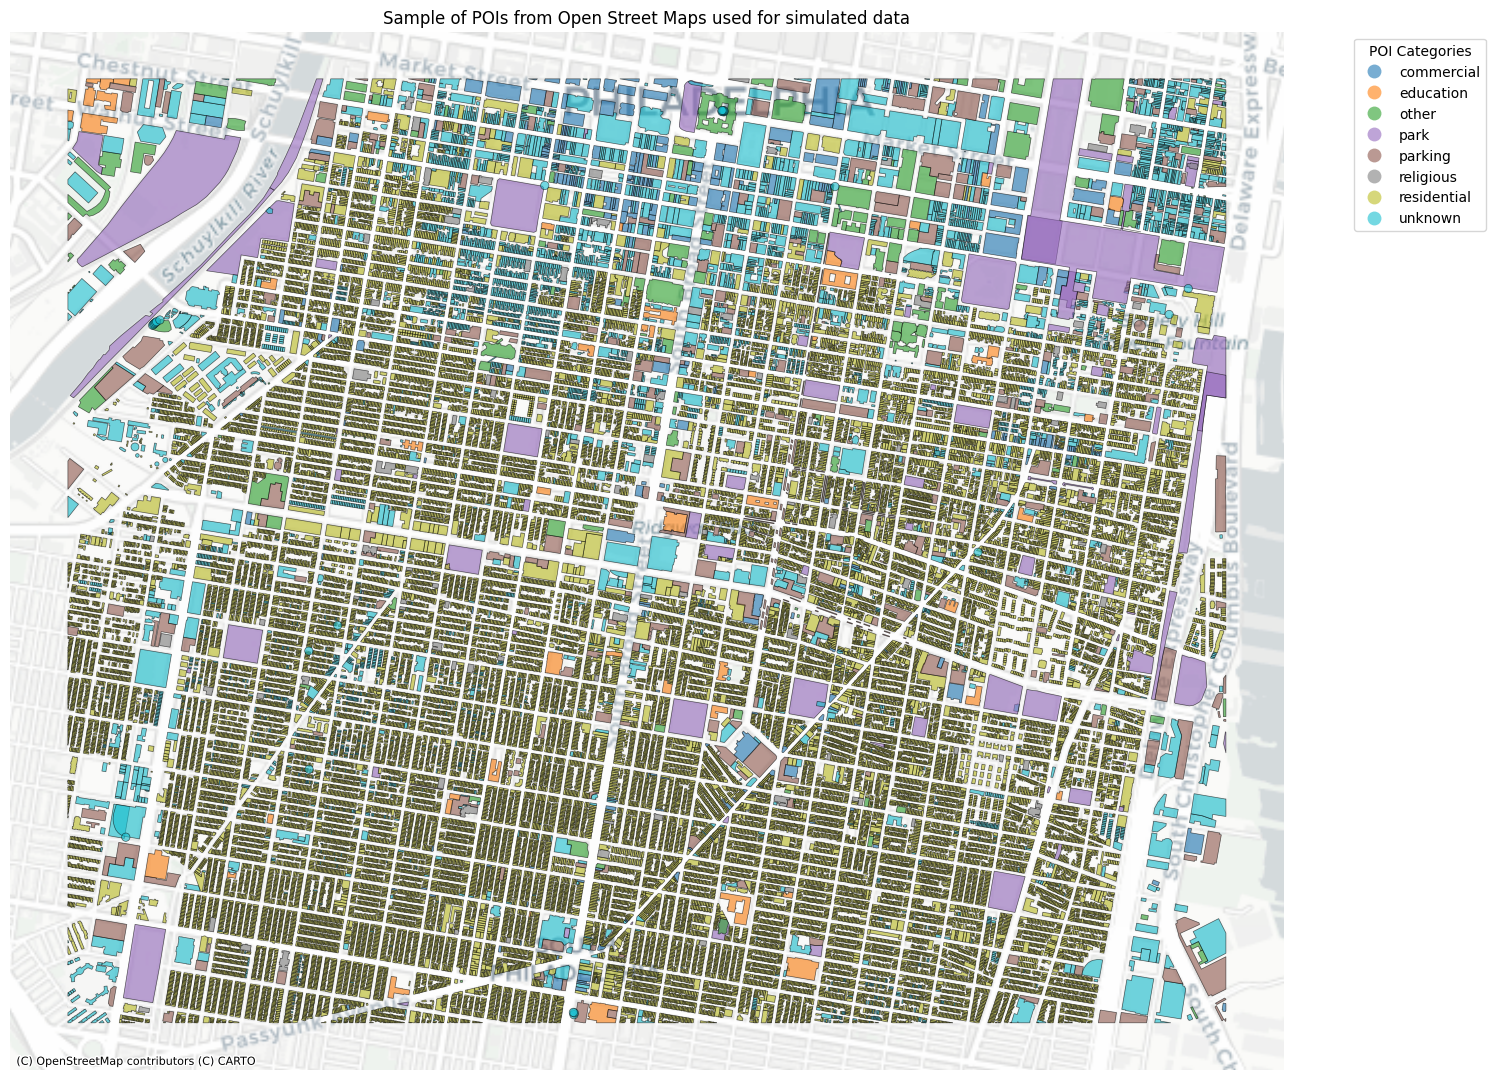

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))
counts = poi_gdf['subtype'].value_counts()
keep_cats = counts[counts > 50].index.tolist()
poi_gdf['plot_cat'] = poi_gdf['subtype'].apply(lambda x: x if x in keep_cats else 'other')
poi_gdf.plot(
    column='plot_cat',
    ax=ax, 
    categorical=True,
    legend=True,
    cmap='tab10',
    alpha=0.6, 
    edgecolor='black', 
    linewidth=0.5, 
    legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left', 'title': 'POI Categories'}
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Sample of POIs from Open Street Maps used for simulated data")
ax.set_axis_off()
plt.tight_layout()
plt.show()

## 3. Trajectory Visualization

We visualize trajectories for 3 sample users on a single day. 
- **Black dots**: Individual location pings
- **Red circles**: Ground truth stops 

In [11]:
stop_df_day

datetime   timestamp  duration     location         user_id  \
51    2025-06-04 20:00:30  1749085230        65         None  admiring_curie   
52    2025-06-04 21:05:30  1749089130       655   h-x127-y17  admiring_curie   
53    2025-06-05 08:00:30  1749128430       112         None  admiring_curie   
54    2025-06-05 09:52:30  1749135150         8  w-x239-y274  admiring_curie   
55    2025-06-05 10:00:30  1749135630         5         None  admiring_curie   
...                   ...         ...       ...          ...             ...   
71731 2025-06-05 13:45:30  1749149130        82         None      zen_colden   
71732 2025-06-05 15:07:30  1749154050       128   w-x50-y280      zen_colden   
71733 2025-06-05 17:15:30  1749161730        85         None      zen_colden   
71734 2025-06-05 18:41:00  1749166860         4  r-x131-y278      zen_colden   
71735 2025-06-05 18:45:30  1749167130        83         None      zen_colden   

                  x             y  tz_offset admin_1_id admin_2_id  \
51              NaN           NaN     -18000         US      US.PA   
52    -8.369024e+06  4.854881e+06     -18000         US      US.PA   
53              NaN           NaN     -18000         US      US.PA   
54    -8.366681e+06  4.858373e+06     -18000         US      US.PA   
55              NaN           NaN     -18000         US      US.PA   
...             ...           ...        ...        ...        ...   
71731           NaN           NaN     -18000         US      US.PA   
71732 -8.369454e+06  4.858969e+06     -18000         US      US.PA   
71733           NaN           NaN     -18000         US      US.PA   
71734 -8.368252e+06  4.858705e+06     -18000         US      US.PA   
71735           NaN           NaN     -18000         US      US.PA   

      event_start_date  
51          2025-06-05  
52          2025-06-05  
53          2025-06-05  
54          2025-06-05  
55          2025-06-05  
...                ...  
71731       2025-06-05  
71732       2025-06-05  
71733       2025-06-05  
71734       2025-06-05  
71735       2025-06-05  

[2418 rows x 11 columns]

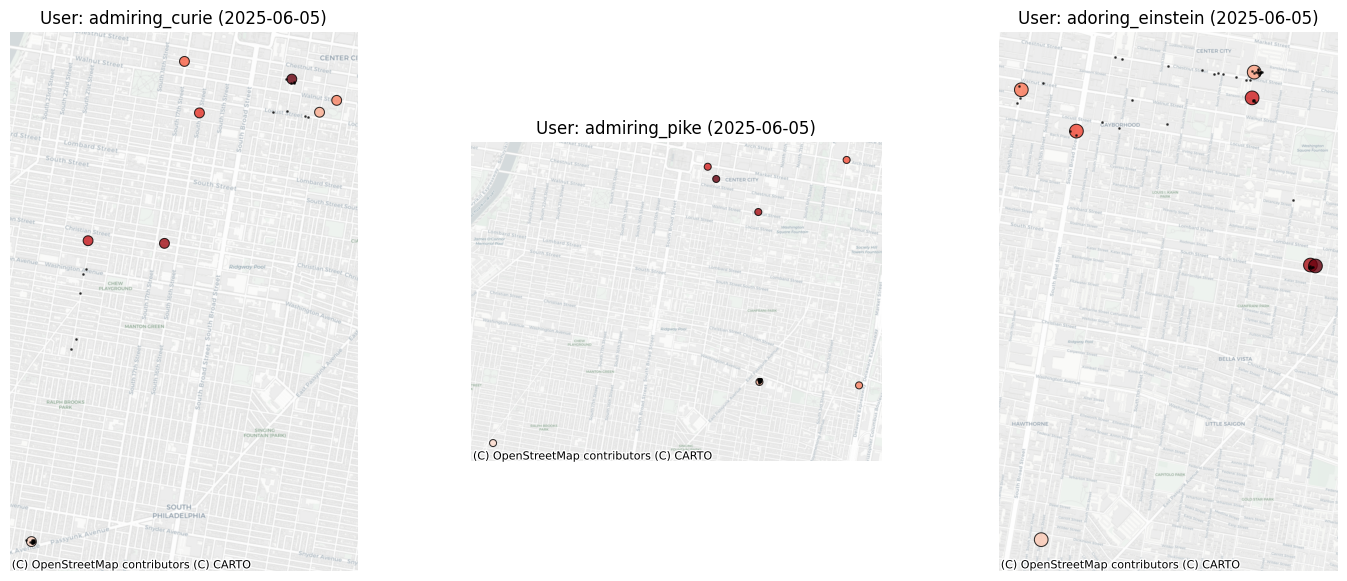

In [18]:
sample_date = device_df['event_start_date'].value_counts().index[0]
device_df_day = device_df[device_df['event_start_date'] == sample_date]
stop_df_day = stop_df[stop_df['event_start_date'] == sample_date]

selected_users = device_df_day.user_id.unique()[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

for i, user_id in enumerate(selected_users):
    ax = axes[i]
    
    user_pings = device_df_day.query("user_id == @user_id")
    user_stops = stop_df_day.query("(user_id == @user_id) and (location != None)").copy()
    user_stops['cluster'] = range(1, len(user_stops) + 1)
    
    viz.plot_pings(user_pings, ax, color='black', s=1, alpha=0.6)
    viz.plot_stops(user_stops, ax, radius=40, cmap='Reds', traj_cols={'x': 'x', 'y': 'y'})
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title(f"User: {user_id} ({sample_date})")
    ax.set_axis_off()

#plt.tight_layout()
plt.show()

## 4. Data Completeness Analysis

We assess data completeness at two temporal resolutions:
- **Hourly**: Proportion of hours in which each user has at least one ping
- **Daily**: Proportion of days in which each user has at least one ping

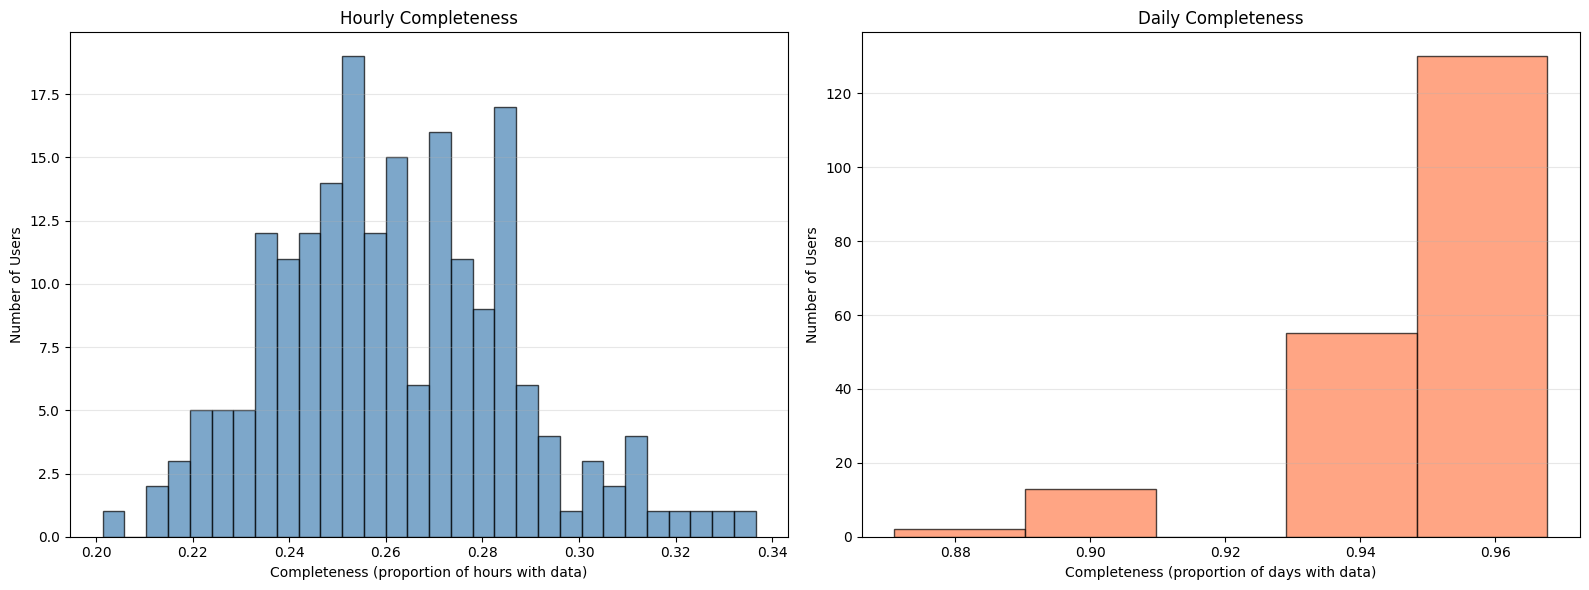

Completeness Statistics:
  Hourly  - Mean: 0.262, Median: 0.259
  Daily   - Mean: 0.954, Median: 0.968


In [21]:
comp_hourly = filters.completeness(device_df, periods=1, freq='h', user_id='user_id', timestamp='timestamp')
comp_daily = filters.completeness(device_df, periods=1, freq='d', user_id='user_id', timestamp='timestamp')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hourly: reduced bins
axes[0].hist(comp_hourly, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Completeness (proportion of hours with data)')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Hourly Completeness')
axes[0].grid(axis='y', alpha=0.3)

# Daily: 10 bins for clearer visualization
axes[1].hist(comp_daily, bins=5, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Completeness (proportion of days with data)')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Daily Completeness')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Completeness Statistics:")
print(f"  Hourly  - Mean: {comp_hourly.mean():.3f}, Median: {comp_hourly.median():.3f}")
print(f"  Daily   - Mean: {comp_daily.mean():.3f}, Median: {comp_daily.median():.3f}")

## 5. Dataset Statistics

In [22]:
pings_per_user = device_df.groupby('user_id').size()

print(f"Number of users: {device_df['user_id'].nunique()}")
print(f"Total pings: {len(device_df):,}")
print(f"Pings per user - Mean: {pings_per_user.mean():.0f}, Median: {pings_per_user.median():.0f}")
print(f"Pings per user - Min: {pings_per_user.min()}, Max: {pings_per_user.max()}")

Number of users: 200
Total pings: 184,367
Pings per user - Mean: 922, Median: 914
Pings per user - Min: 624, Max: 1268


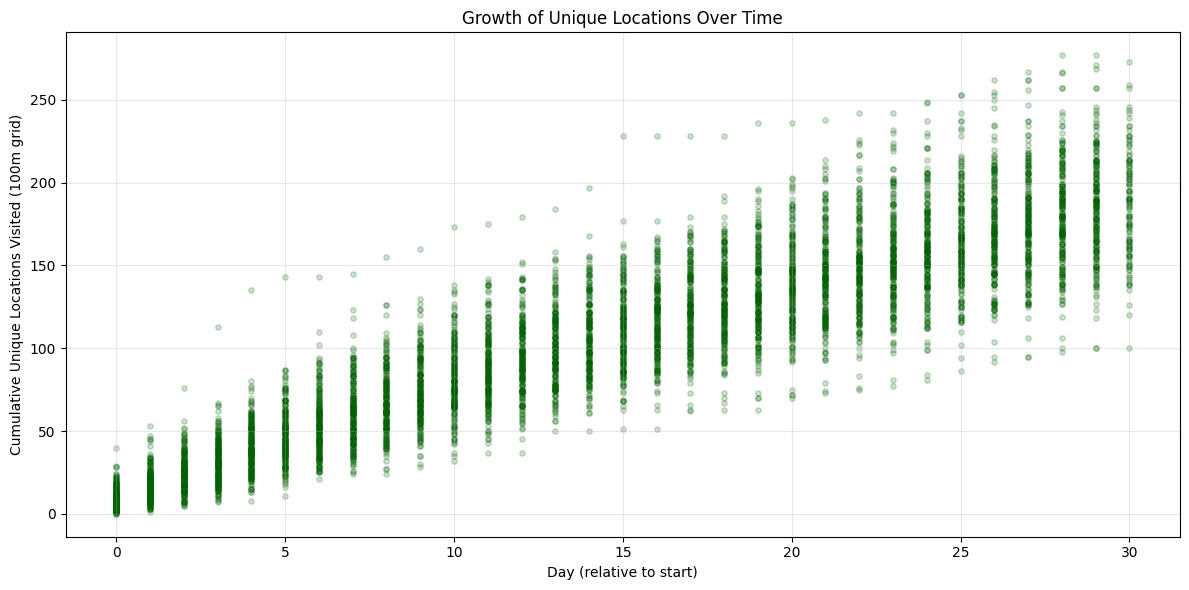

In [23]:
# Create unique location identifier from rounded coordinates (100m grid)
device_df['loc_grid'] = (device_df['x'] // 100).astype(str) + '_' + (device_df['y'] // 100).astype(str)

# Compute cumulative unique locations for each user over time
device_df['day_num'] = (pd.to_datetime(device_df['event_start_date']) - pd.to_datetime(device_df['event_start_date']).min()).dt.days

cumulative_locations = []
for user_id in device_df['user_id'].unique():
    user_data = device_df[device_df['user_id'] == user_id].sort_values('timestamp')
    for day in range(user_data['day_num'].max() + 1):
        locs_up_to_day = user_data[user_data['day_num'] <= day]['loc_grid'].nunique()
        cumulative_locations.append({'day': day, 'cumulative_locations': locs_up_to_day})

cum_loc_df = pd.DataFrame(cumulative_locations)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(cum_loc_df['day'], cum_loc_df['cumulative_locations'], alpha=0.2, s=15, color='darkgreen')
ax.set_xlabel('Day (relative to start)')
ax.set_ylabel('Cumulative Unique Locations Visited (100m grid)')
ax.set_title('Growth of Unique Locations Over Time')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()